[*********************100%***********************]  1 of 1 completed
(78, 5)
(77, 6)
(69, 1)
(8, 1)
0.09217161884632118
<bound method UnitRootTest.summary of <class 'arch.unitroot.unitroot.VarianceRatio'>
"""
     Variance-Ratio Test Results     
Test Statistic                 -1.496
P-value                         0.135
Lags                               10
-------------------------------------

Computed with overlapping blocks (de-biased)
""">
Mean Reverting


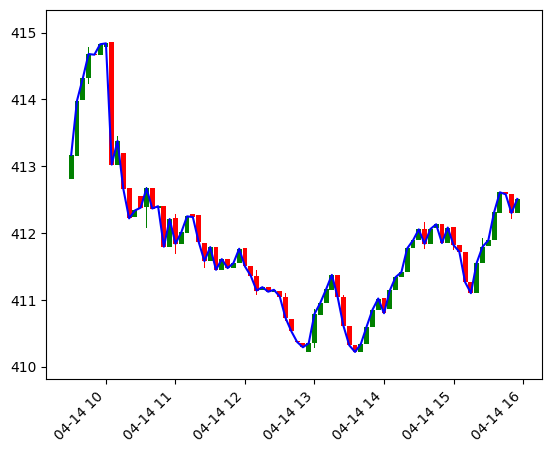

In [55]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from arch import arch_model
import numpy as np
from scipy.stats import chisquare
from arch.unitroot import VarianceRatio

class Signal():
    def __init__(self,interval = '5m',periodi= 1 ):
        # consider the top 10 holdings of the SPY
        # include the SPY for portfolio diversity tech growth
        self.period =periodi
        period = str(self.period)+'d'
        self.targetcol = '1DayRet_'+'Close'
        
        self.tickers = ['SPY']
        self.feat = ['Open','Low','High','Close','Volume']
        self.X = yf.download(tickers =self.tickers,period = period, interval = interval)[self.feat]

        #self.X.index = pd.DatetimeIndex(self.X.index).to_period('D')
        #self.X= self.X.dropna()
        print(self.X.shape)

        up = self.X[self.X.Close >= self.X.Open]
        down = self.X[self.X.Close < self.X.Open]


        col1 = 'green'
        col2 = 'red'

        width = .0029
        width2 = .00009

#plot up prices
         # width = .4
      #  width2 = .05

#plot up prices
        plt.bar(up.index,up.Close-up.Open,width,bottom=up.Open,color=col1)
        plt.bar(up.index,up.High-up.Close,width2,bottom=up.Close,color=col1)
        plt.bar(up.index,up.Low-up.Open,width2,bottom=up.Open,color=col1)

#plot down prices
        plt.bar(down.index,down.Close-down.Open,width,bottom=down.Open,color=col2)
        plt.bar(down.index,down.High-down.Open,width2,bottom=down.Open,color=col2)
        plt.bar(down.index,down.Low-down.Close,width2,bottom=down.Close,color=col2)
        plt.plot(self.X.index, self.X.Close, color ='blue',label='Closing Price')

#rotate x-axis tick labels
        plt.xticks(rotation=45, ha='right')

#display candlestick chart
       # plt.show()


        pass
    @staticmethod
    def OGfrac(x, d):
        if np.isnan(np.sum(x)):
            return None

        n = len(x)
        if n < 2:
            return None

        x = np.subtract(x, np.mean(x))

    # calculate weights
        weights = [0] * n
        weights[0] = -d
        for k in range(2, n):
            weights[k - 1] = weights[k - 2] * (k - 1 - d) / k

    # difference series
        ydiff = list(x)

        for i in range(0, n):
            dat = x[:i]
            w = weights[:i]
            ydiff[i] = x[i] + np.dot(w, dat[::-1])

        return ydiff
     
    def LogChangeFracDiff(self):
        self.X['5mRet_'+'Close'] = np.log(self.X.Close) - np.log(self.X.Close.shift(1))

        self.X= self.X.dropna()

       # print(self.X['5mRet_'+'Close'])
        
       # print(self.OGfrac(self.X['5mRet_'+'Close'].values.reshape(-1,1),0.25))
        self.InvTransform = self.X['5mRet_'+'Close'].values.reshape(-1,1) -  np.array(self.OGfrac(self.X['5mRet_'+'Close'].values.reshape(-1,1),0.25)).ravel().reshape(-1,1)
        
        self.X['5mRet_'+'Close'] = np.array(self.OGfrac(self.X['5mRet_'+'Close'].values.reshape(-1,1),0.35)).ravel().reshape(-1,1)

        return self.X
    

    def GARCH(self):
        
        fig, ax = plt.subplots()
        #self.X = self.LogChangeFracDiff()
        print(self.X.shape)
        testendog = 10000*self.X['5mRet_'+'Close'][int( 0.90* self.X.shape[0]):self.X.shape[0]].values.reshape(-1,1)
        trainendog = 10000*self.X['5mRet_'+'Close'][0:int( 0.90* self.X.shape[0])].values.reshape(-1,1)
        print(trainendog.shape)
        print(testendog.shape)

        am = arch_model(trainendog, vol ="GARCH",p=1 ,o=2,q =1)
        model_g  = am.fit(update_freq=5)
        forecasts = model_g.forecast(horizon=testendog.shape[0],method='simulation',simulations = 100)
        var = forecasts.simulations.variances.T
        resvar = forecasts.simulations.residual_variances.T
        #cond_var = forecasts.conditional_volatility

        ts = np.arange(0,testendog.shape[0],1)


        print(var[:,:,-1].shape)

        ax.plot(self.X[trainendog.shape[0]: trainendog.shape[0] + testendog.shape[0]].index, (var[:,0,-1])/1000 , label = 'Simulations of var GARCH',c ='b')
       # ax.plot(self.X[trainendog.shape[0]: trainendog.shape[0] + testendog.shape[0]].index, (resvar[:,0,-1])/1000 , label = 'Simulations of residual var GARCH',c ='green')
        ax.plot(self.X[trainendog.shape[0]: trainendog.shape[0] + testendog.shape[0]].index,testendog/1000  - self.InvTransform[trainendog.shape[0]: trainendog.shape[0] + testendog.shape[0]],label='Actual data',c='r')
        ax.set_title('Cond Var simulation SPY')
        ax.set_xlabel(' Time(5m scale )')
        ax.set_ylabel(' Return 7  s(log)')
        ax.legend(loc = 'upper left',fontsize ='1')

    @staticmethod
    def VarianceRatioTest(endog,lags = 10 ):
        VRT = VarianceRatio(endog,lags =lags)
        print(VRT.vr)
        return VRT.summary

        

        

    def Hurst(self):

        #fig, ax = plt.subplots()
        self.X = self.LogChangeFracDiff()
        print(self.X.shape)
        testendog = 10000*self.X['5mRet_'+'Close'][int( 0.90* self.X.shape[0]):self.X.shape[0]].values.reshape(-1,1)
        trainendog = 10000*self.X['5mRet_'+'Close'][0:int( 0.90* self.X.shape[0])].values.reshape(-1,1)
        print(trainendog.shape)
        print(testendog.shape)
        lags = range(1,10)

        tau =[np.sqrt(np.std(trainendog[lag:] - trainendog[:-lag])) for lag in lags]

        poly = np.polyfit(np.log(lags),tau,1) 

        H= poly[0]*2.0 

        print(self.VarianceRatioTest(trainendog))

        if H < 0.5:
            print('Mean Reverting')
        elif H ==0.5:
            print(' Geometric Brownian Motion')
        elif H> 0.5:
            print('Nonstationary trend')


        

        

g = Signal()
g.Hurst()
#g.GARCH()